Final Project PART2

Team member : Kimi Chi(Also leader)

It is an indivisual team, so 100% contribute to myself.

In [92]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import PyPDF2
from docx import Document
import warnings
warnings.filterwarnings('ignore')

In [93]:
df = pd.read_csv('IEA-EV-dataEV salesCarsHistorical.csv')
df.head()


,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49
1,Australia,Historical,EV sales,Cars,BEV,2012,Vehicles,170
2,Australia,Historical,EV sales,Cars,PHEV,2012,Vehicles,80
3,Australia,Historical,EV sales,Cars,PHEV,2013,Vehicles,100
4,Australia,Historical,EV sales,Cars,BEV,2013,Vehicles,190


In [94]:
df.tail()

,region,category,parameter,mode,powertrain,year,unit,value
829,World,Historical,EV sales,Cars,PHEV,2020,Vehicles,970000
830,World,Historical,EV sales,Cars,PHEV,2021,Vehicles,1900000
831,World,Historical,EV sales,Cars,BEV,2021,Vehicles,4600000
832,World,Historical,EV sales,Cars,BEV,2022,Vehicles,7300000
833,World,Historical,EV sales,Cars,PHEV,2022,Vehicles,2900000


In [95]:
df.describe()

,year,value
count,834.000000,8.340000e+02
mean,2016.579137,8.141432e+04
std,3.511476,4.072362e+05
min,2010.000000,1.000000e+00
25%,2014.000000,3.400000e+02
50%,2017.000000,3.100000e+03
75%,2020.000000,2.300000e+04
max,2022.000000,7.300000e+06


In [96]:
df.dtypes

region        object
category      object
parameter     object
mode          object
powertrain    object
year           int64
unit          object
value          int64
dtype: object

In [97]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
region        0
category      0
parameter     0
mode          0
powertrain    0
year          0
unit          0
value         0
dtype: int64


In [98]:
df.sort_values(by='year', inplace=True)

In [99]:
df.reset_index(drop=True, inplace=True)

In [100]:
print("\nPreprocessed Data:")
print(df.head())


Preprocessed Data:
    region    category parameter  mode powertrain  year      unit  value
0     EU27  Historical  EV sales  Cars        BEV  2010  Vehicles   1400
1    Korea  Historical  EV sales  Cars        BEV  2010  Vehicles     61
2   Sweden  Historical  EV sales  Cars        BEV  2010  Vehicles      4
3  Belgium  Historical  EV sales  Cars        BEV  2010  Vehicles     48
4    Japan  Historical  EV sales  Cars        BEV  2010  Vehicles   2400


TRENDS IN ELECTRIC VEHICLES ACROSS ALL REGIONS USING LINE PLOTS

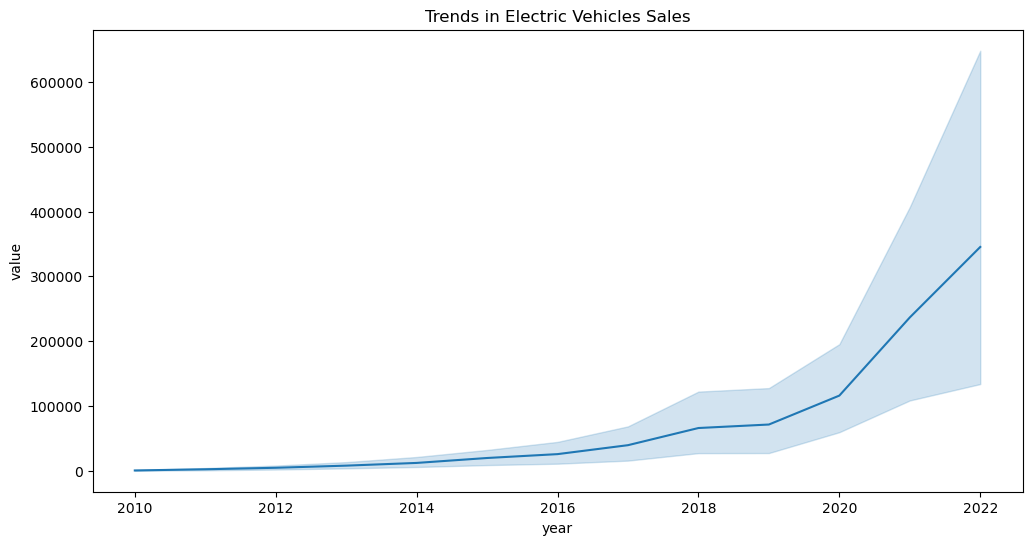

In [101]:
plt.figure(figsize=(12,6))
sns.lineplot(x='year', y='value', data=df)
plt.title('Trends in Electric Vehicles Sales')
plt.xlabel('year')
plt.ylabel('value')
plt.show()



There has been gradual increase in Electric vehicle sales and more especially between 2016 to 2022

TIME SERIES DECOMPOSITION

In [102]:
decomposition = seasonal_decompose(df['value'], model='additive', period=12)

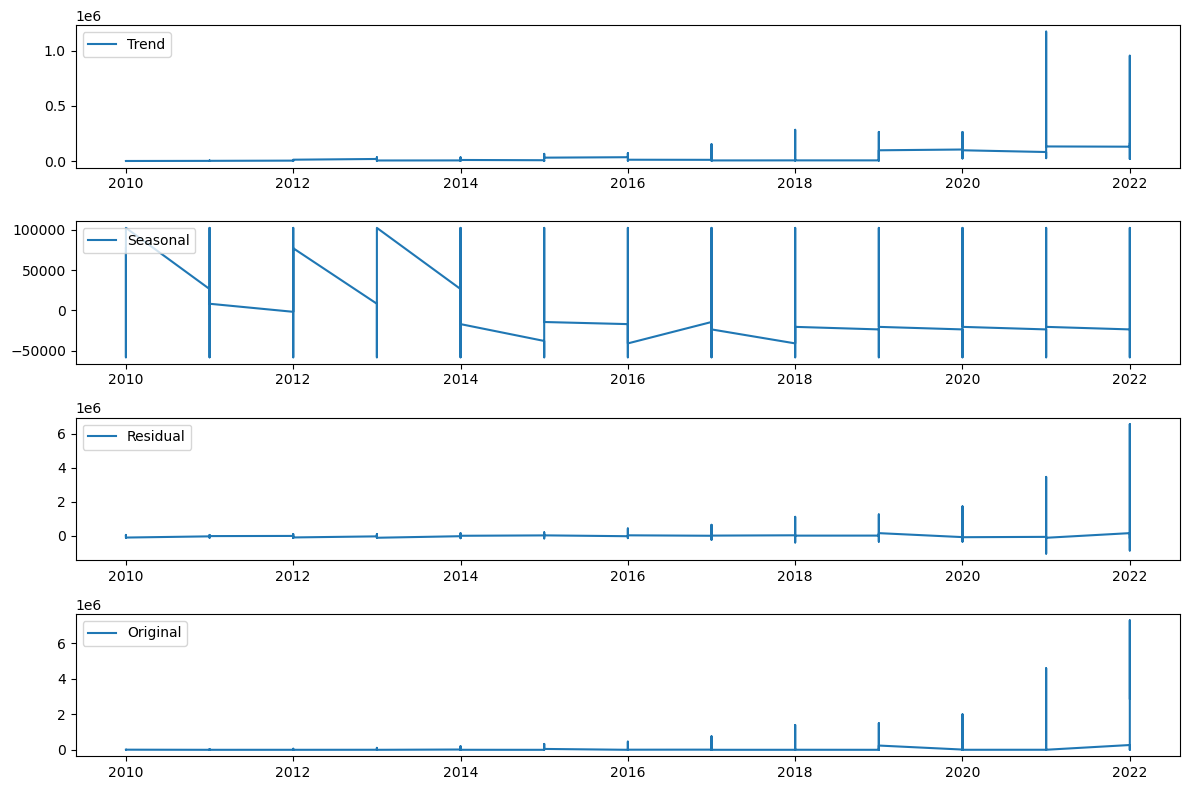

In [103]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['year'], decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(df['year'], decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df['year'], decomposition.resid, label='Residual')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(df['year'], df['value'], label='Original')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

STATIONARITY

In [104]:
result= adfuller(df['value'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -4.336208203174369
p-value: 0.00038427103570876244
Critical Values: {'1%': -3.4384189633001956, '5%': -2.86510158480911, '10%': -2.568666500743605}


The data is not stationary.

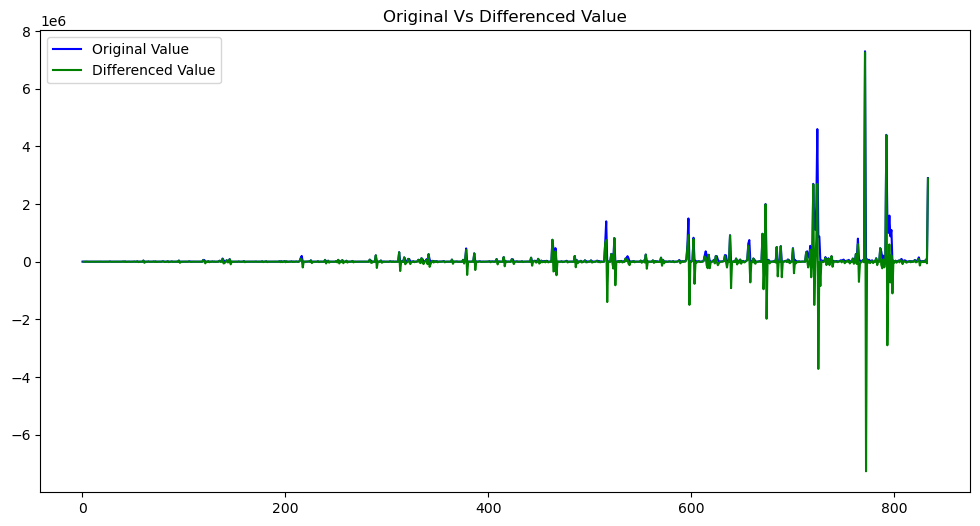

In [105]:
df['value_diff'] = df['value'].diff()
plt.figure(figsize = (12,6))
plt.plot(df['value'], label='Original Value', color='blue')
plt.plot(df['value_diff'], label='Differenced Value', color='green')
plt.legend()
plt.title('Original Vs Differenced Value')
plt.show()

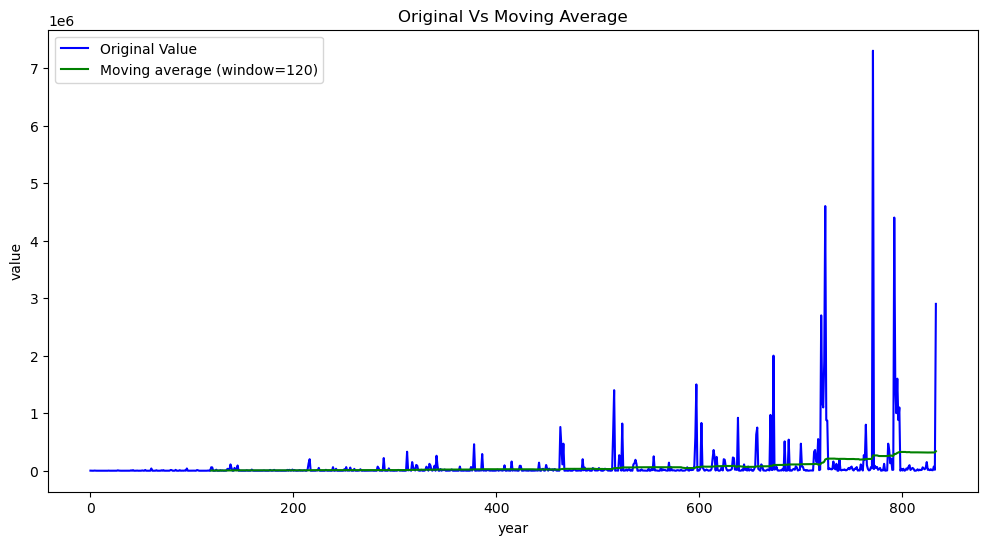

In [106]:
window_size = 120
df['value_smoothed'] = df['value'].rolling(window=window_size).mean()
plt.figure(figsize = (12,6))
plt.plot(df['value'], label='Original Value', color='blue')
plt.plot(df['value_smoothed'], label=f'Moving average (window={window_size})', color='green')
plt.xlabel('year')
plt.ylabel('value')
plt.legend()
plt.title('Original Vs Moving Average')
plt.show()

In [107]:
df_combined = pd.concat([df['value'], df['value_diff']], axis=1)
print(df_combined.head())

   value  value_diff
0   1400         NaN
1     61     -1339.0
2      4       -57.0
3     48        44.0
4   2400      2352.0


In [108]:
df.dropna(subset=['value_diff'], inplace=True)
df['value_diff'].head()

1   -1339.0
2     -57.0
3      44.0
4    2352.0
5   -1680.0
Name: value_diff, dtype: float64

In [109]:
result= adfuller(df['value_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -12.580296372627302
p-value: 1.9170110614100752e-23
Critical Values: {'1%': -3.4384189633001956, '5%': -2.86510158480911, '10%': -2.568666500743605}


The data is now stationary.

AUTOCORRELATION ANALYSIS (ACF)

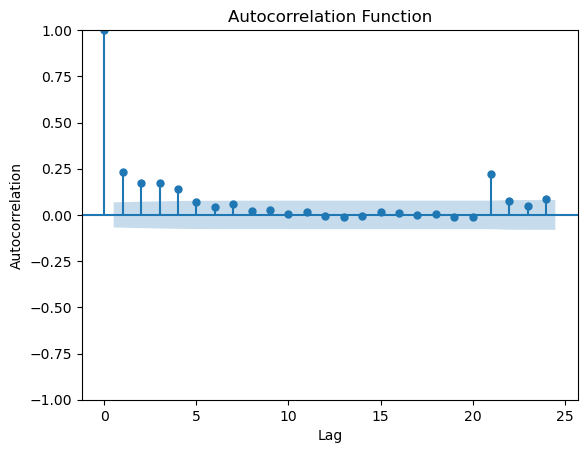

In [110]:
# plt.figure(figsize=(12,6))
plot_acf(df['value'], lags=24)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.show()


PREDICTIVE ANALYSIS

ARIMA

In [111]:
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.set_index('year', inplace=True)

In [112]:
# Split the data
train_size = int(len(df) * 0.8)  # 80% of the data for training
train_data = df[:train_size]['value']
test_data = df[train_size:]['value']

In [113]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Train ARIMA model
model = ARIMA(train_data, order=(5, 1, 0))
results = model.fit()

#Forecast
forecast_steps = len(test_data)  # Forecast the same number of steps as test set
forecast = results.forecast(steps=forecast_steps)

# Get actual values for the forecast period
actual_values = test_data

# Evaluate forecast
mae = mean_absolute_error(actual_values, forecast)
mse = mean_squared_error(actual_values, forecast)
rmse = np.sqrt(mse)
#mape = np.mean(np.abs((actual_values - forecast) / actual_values)) * 100

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
#print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Error (MAE): 268478.7692181672
Mean Squared Error (MSE): 786806002049.6273
Root Mean Squared Error (RMSE): 887020.8577308807


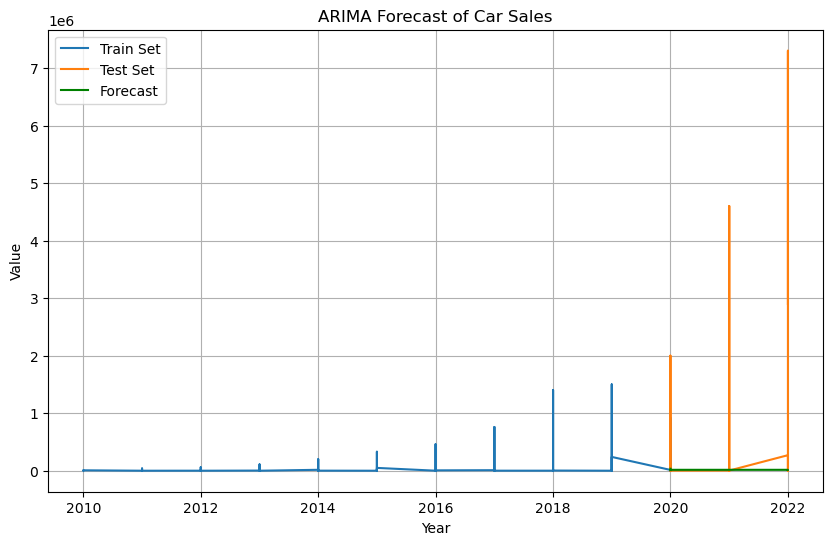

In [114]:

plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Train Set')
plt.plot(test_data.index, test_data, label='Test Set')
plt.plot(test_data.index, forecast, color='green', label='Forecast')
plt.legend()
plt.title('ARIMA Forecast of Car Sales')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True)
plt.show()



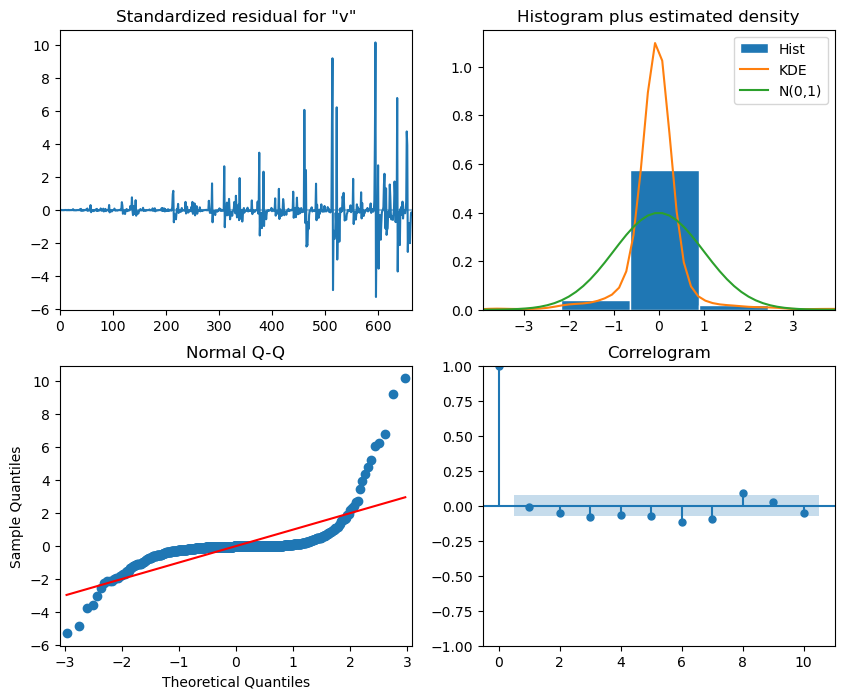

In [115]:
#plot diagnostics
results.plot_diagnostics(figsize=(10,8))
plt.show()

USING XGBoost

In [116]:
data = pd.read_csv('IEA-EV-dataEV salesCarsHistorical.csv')

In [117]:
data.head()

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49
1,Australia,Historical,EV sales,Cars,BEV,2012,Vehicles,170
2,Australia,Historical,EV sales,Cars,PHEV,2012,Vehicles,80
3,Australia,Historical,EV sales,Cars,PHEV,2013,Vehicles,100
4,Australia,Historical,EV sales,Cars,BEV,2013,Vehicles,190


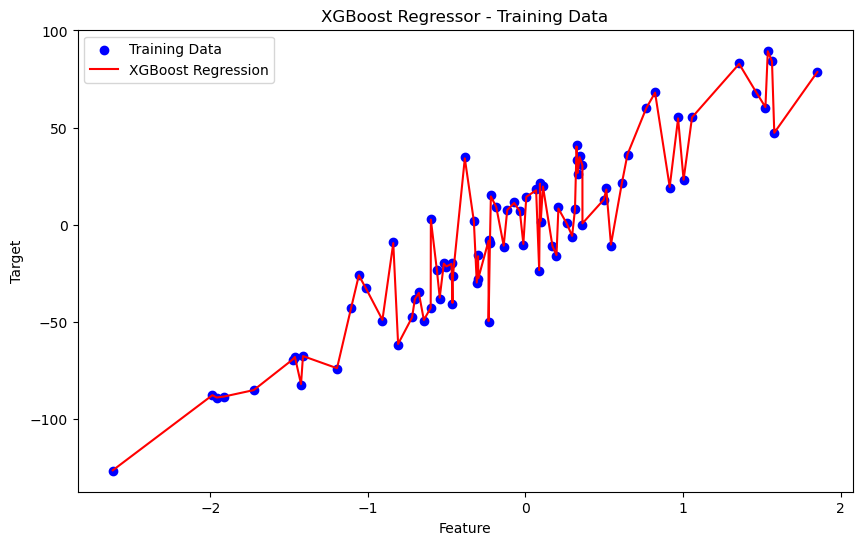

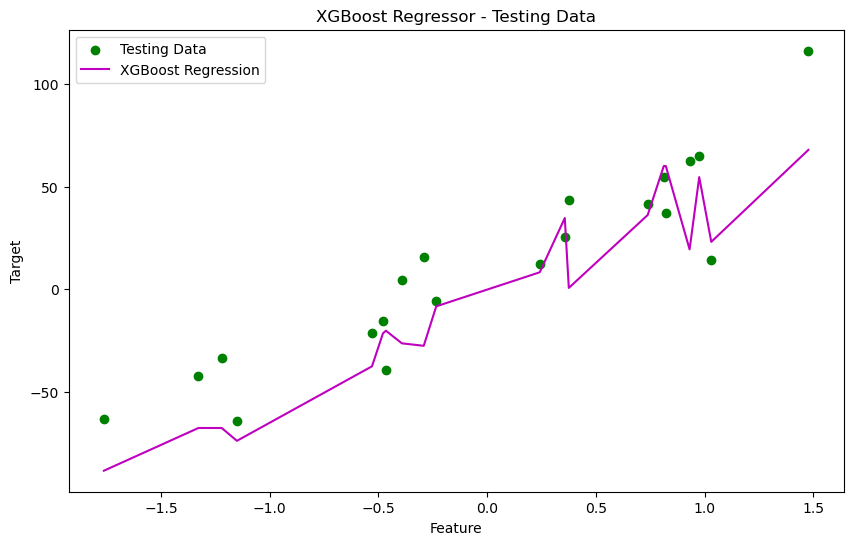

Mean Absolute Error (MAE): 56.48502834490639
Mean Squared Error (MSE): 5055.31714874643
Root Mean Squared Error (RMSE): 887020.8577308807
Mean Absolute Percentage Error (MAPE): 20.000000309876455


In [118]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X = data['year']
y = data['value']
# Generate some synthetic data for demonstration
X, y = make_regression(n_samples=100, n_features=1, noise=20, random_state=42)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBRegressor
regressor = XGBRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# Visualize the training data
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, c='b', label='Training Data')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('XGBoost Regressor - Training Data')

# Plot the regressor's predictions on training data
X_train_sorted = np.sort(X_train, axis=0)
y_train_pred = regressor.predict(X_train_sorted)
plt.plot(X_train_sorted, y_train_pred, c='r', label='XGBoost Regression')

plt.legend()
plt.show()

# Visualize the testing data
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, c='g', label='Testing Data')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('XGBoost Regressor - Testing Data')

# Plot the regressor's predictions on testing data
X_test_sorted = np.sort(X_test, axis=0)
y_test_pred = regressor.predict(X_test_sorted)
plt.plot(X_test_sorted, y_test_pred, c='m', label='XGBoost Regression')

plt.legend()
plt.show()

# Evaluate forecast
mae_xgb = mean_absolute_error(y_test, y_test_pred)
mse_xgb = mean_squared_error(y_test, y_test_pred)
rmse_xgb = np.sqrt(mse)
mape_xgb = np.mean(np.abs(y_test, y_test_pred) / y_test) * 100

print("Mean Absolute Error (MAE):", mae_xgb)
print("Mean Squared Error (MSE):", mse_xgb)
print("Root Mean Squared Error (RMSE):", rmse_xgb)
print("Mean Absolute Percentage Error (MAPE):", mape_xgb)


USING Light GBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1
[LightGBM] [Info] Start training from score -5.815799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

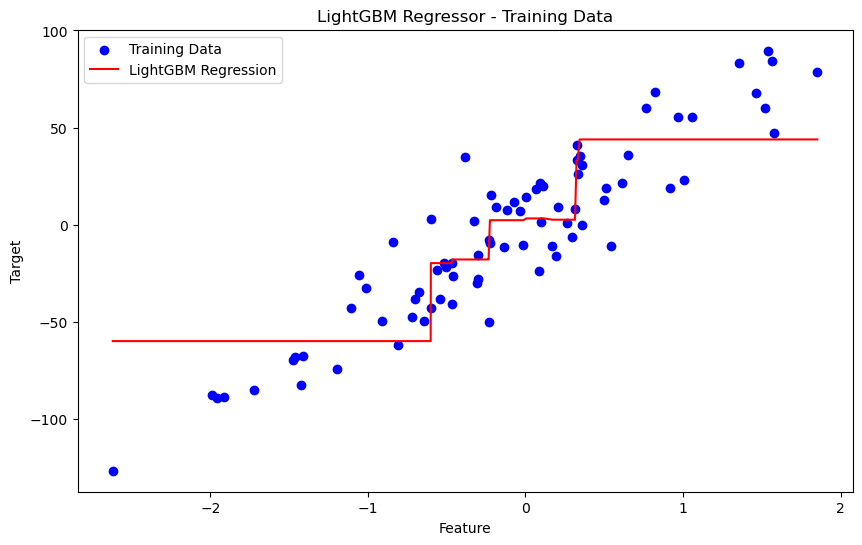

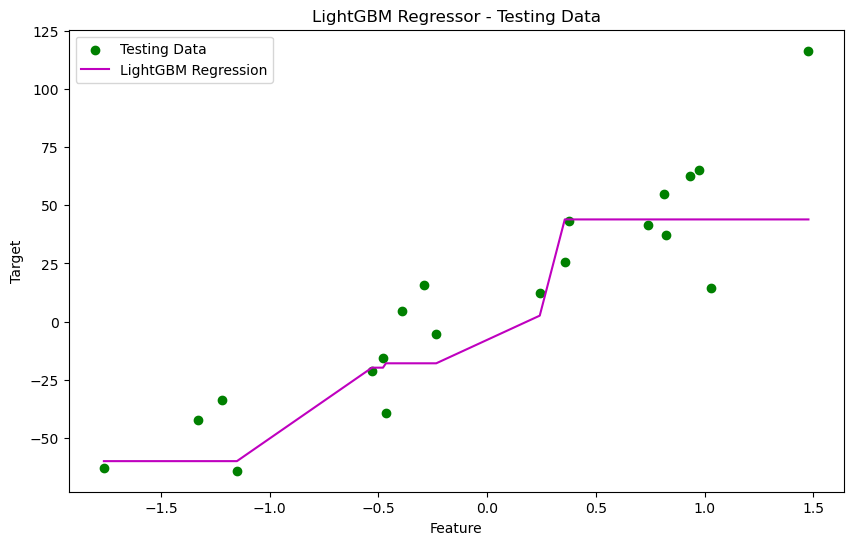

Mean Absolute Error (MAE): 51.041913444254575
Mean Squared Error (MSE): 4479.971336123717
Root Mean Squared Error (RMSE): 887020.8577308807
Mean Absolute Percentage Error (MAPE): 20.0


In [119]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Generate some synthetic data for demonstration
X, y = make_regression(n_samples=100, n_features=1, noise=20, random_state=42)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data into LightGBM Dataset format
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Set parameters for the LightGBM Regressor
params = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose': 1,  
}

# Train LightGBM Regressor
num_round = 100
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_test])


# Visualize the training data
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, c='b', label='Training Data')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('LightGBM Regressor - Training Data')

# Plot the regressor's predictions on training data
X_train_sorted = np.sort(X_train, axis=0)
y_train_pred = bst.predict(X_train_sorted)
plt.plot(X_train_sorted, y_train_pred, c='r', label='LightGBM Regression')

plt.legend()
plt.show()

# Visualize the testing data
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, c='g', label='Testing Data')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('LightGBM Regressor - Testing Data')

# Plot the regressor's predictions on testing data
X_test_sorted = np.sort(X_test, axis=0)
y_test_pred = bst.predict(X_test_sorted)
plt.plot(X_test_sorted, y_test_pred, c='m', label='LightGBM Regression')

plt.legend()
plt.show()

# Evaluate forecast
mae_lgb = mean_absolute_error(y_test, y_test_pred)
mse_lgb = mean_squared_error(y_test, y_test_pred)
rmse_lgb = np.sqrt(mse)
mape_lgb = np.mean(np.abs(y_test, y_test_pred) / y_test) * 100

print("Mean Absolute Error (MAE):", mae_lgb)
print("Mean Squared Error (MSE):", mse_lgb)
print("Root Mean Squared Error (RMSE):", rmse_lgb)
print("Mean Absolute Percentage Error (MAPE):", mape_lgb)

CHINESE ELECTRIC VEHICLE ANALYSIS

In [120]:
with open('preview.pdf', 'rb') as file:
    pdf_reader = PyPDF2.PdfReader(file)
    text = ''
    for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        text += page.extract_text()


In [121]:
print(text)

S1 Table. Sales of BEV and PHEV in China from January 2011 to December 2015
Year/Month BEV sales PHEV sales
2011/01 588 310
2011/02 47 417
2011/03 159 286
2011/04 173 162
2011/05 305 470
2011/06 319 273
2011/07 535 650
2011/08 917 1323
2011/09 57 688
2011/10 554 663
2011/11 325 896
2011/12 2137 443
2012/01 205 216
2012/02 49 512
2012/03 461 826
2012/04 610 635
2012/05 469 746
2012/06 266 1483
2012/07 364 1728
2012/08 93 1701
2012/09 910 1306
2012/10 1303 1395
2012/11 2161 1999
2012/12 3553 2741
2013/01 1476 436
2013/02 540 197
2013/03 808 583
2013/04 784 546
2013/05 1167 1517
2013/06 588 488
2013/07 752 123
2013/08 935 80
2013/09 1556 52
2013/10 847 1
2013/11 1683 58
2013/12 6985 1373
2014/01 2169 523
2014/02 948 387
2014/03 2386 1589
2014/04 1753 1136
2014/05 1837 1767
11
1
22014/06 2408 1037
2014/07 4090 1709
2014/08 2731 2460
2014/09 5755 4358
2014/10 4071 3160
2014/11 8475 4346
2014/12 22687 6897
2015/01 3451 3148
2015/02 6519 6334
2015/03 9451 4079
2015/04 10382 5730
2015/05 12754

In [122]:
doc = Document('S1Table.docx')
text = ''
for paragraph in doc.paragraphs:
    text += paragraph.text + '\n'

In [123]:
print(text)

S1 Table. Sales of BEV and PHEV in China from January 2011 to December 2015




In [124]:
doc = Document('S1Table.docx')
years = []
months = []
bev_data = []
phev_data = []

header_row = True

for table in doc.tables:
    for row in table.rows:

        if header_row:
            header_row = False
            continue
        cells = [cell.text.strip() for cell in row.cells]
        year_month = cells[0]
        if '/' in year_month:
            year, month = year_month.split('/')
            try:
                years.append(int(year))
                months.append(int(month))
                bev_data.append(float(cells[1]))
                phev_data.append(float(cells[2]))
            except ValueError:
                pass

In [125]:
data = pd.DataFrame({'Year': years, 'Month': months, 'BEV': bev_data, 'PHEV': phev_data})

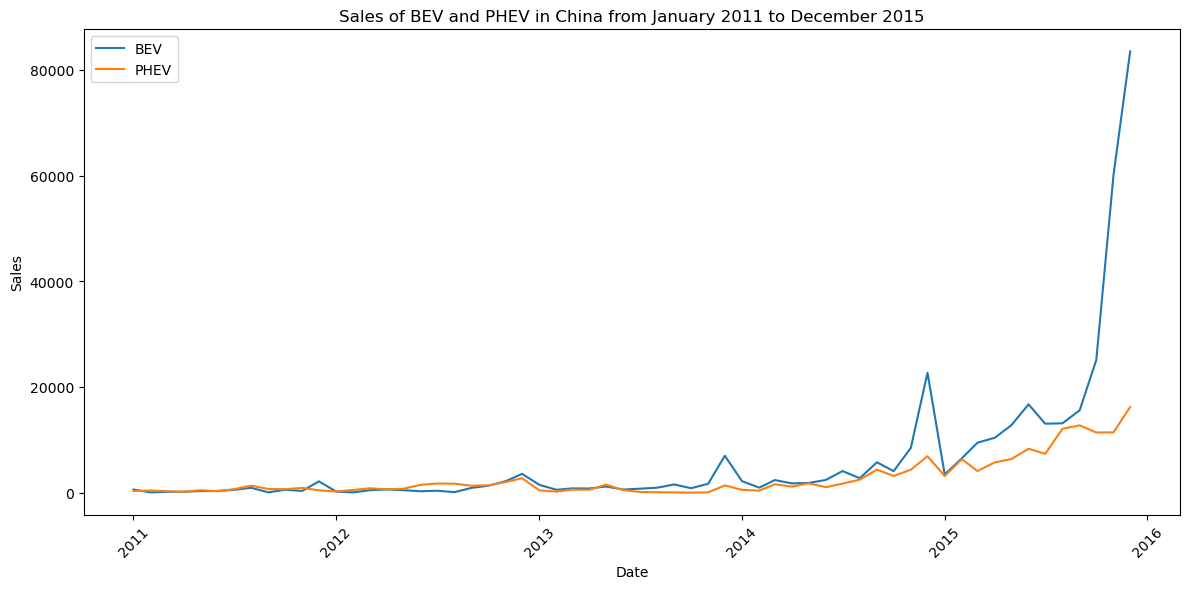

In [126]:
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='BEV', data=data, label='BEV')
sns.lineplot(x='Date', y='PHEV', data=data, label='PHEV')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of BEV and PHEV in China from January 2011 to December 2015')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Between 2013-to-2014 to 2016, BEV have had a higher sales rate compared to PHEV

In [127]:
doc = Document('S2Table.docx')
text = ''
for paragraph in doc.paragraphs:
    text += paragraph.text + '\n'

In [128]:
print(text)

S2 Table. Economic indicators from January 2011 to December 2015




In [129]:
doc = Document('S2Table.docx')
table_data = []
for table in doc.tables:
    for row in table.rows:
        row_data = [cell.text for cell in row.cells]
        table_data.append(row_data)

In [130]:
df = pd.DataFrame(table_data)
print(df)

             0                     1                          2  \
0   Year/Month  Consumer price index  Consumer confidence index   
1      2011/01                 104.9                       99.9   
2      2011/02                 104.9                       99.6   
3      2011/03                 105.4                      107.6   
4      2011/04                 105.3                      106.6   
..         ...                   ...                        ...   
56     2015/08                101.96                        104   
57     2015/09                 101.6                      105.6   
58     2015/10                101.27                      103.8   
59     2015/11                101.49                      104.1   
60     2015/12                101.64                      103.7   

                       3                  4              5           6  
0   Producer price index  Fuel retail price  Vehicle price  Baidu data  
1                  106.6              100.2      

In [131]:
doc = Document('S2Table.docx')
years = []
months = []
consumer_price = []
consumer_confidence = []
producer_price = []
fuel_retail = []
vehicle_price = []

header_row = True

for table in doc.tables:
    for row in table.rows:

        if header_row:
            header_row = False
            continue

        cells = [cell.text.strip() for cell in row.cells]
        if len(cells) >=6:
            year_month = cells[0]
            if '/' in year_month:
                year, month = year_month.split('/')
                try:
                    years.append(int(year))
                    months.append(int(month))
                    consumer_price.append(float(cells[1]))
                    consumer_confidence.append(float(cells[2]))
                    producer_price.append(float(cells[3]))
                    fuel_retail.append(float(cells[4]))
                    vehicle_price.append(float(cells[5]))

                except ValueError:
                    pass

In [132]:
data = pd.DataFrame({'Year': years, 'Month': months, 'CONSUMER PRICE INDEX': consumer_price, 'CONSUMER CONFIDENCE INDEX': consumer_confidence,'PRODUCER PRICE INDEX': producer_price,'FUEL RETAIL PRICE': fuel_retail,'VEHICLE PRICE': vehicle_price})

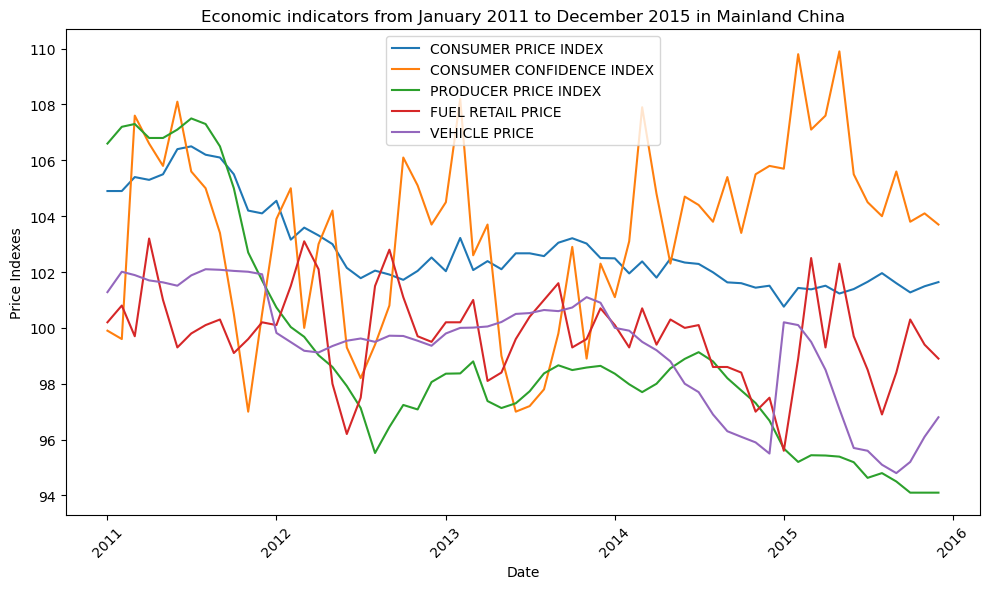

In [133]:
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
plt.figure(figsize=(10,6))
sns.lineplot(x='Date', y='CONSUMER PRICE INDEX', data=data, label='CONSUMER PRICE INDEX')
sns.lineplot(x='Date', y='CONSUMER CONFIDENCE INDEX', data=data, label='CONSUMER CONFIDENCE INDEX')
sns.lineplot(x='Date', y='PRODUCER PRICE INDEX', data=data, label='PRODUCER PRICE INDEX')
sns.lineplot(x='Date', y='FUEL RETAIL PRICE', data=data, label='FUEL RETAIL PRICE')
sns.lineplot(x='Date', y='VEHICLE PRICE', data=data, label='VEHICLE PRICE')
plt.xlabel('Date')
plt.ylabel('Price Indexes')
plt.title('Economic indicators from January 2011 to December 2015 in Mainland China')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [134]:
df = pd.read_csv('Carsdata.csv')

In [135]:
df.head()

,Registration Date,Quantity Industry Registration,Sales Type,Manufacturer Description
0,1/3/2005,1/14/1900,NaN,VOLVO
1,1/3/2005,1/6/1900,NaN,LAND ROVER
2,1/3/2005,3/25/1900,NaN,HONDA
3,1/3/2005,2/4/1900,NaN,CITROEN
4,1/3/2005,3/21/1900,NaN,PEUGEOT


In [136]:
df.tail()

,Registration Date,Quantity Industry Registration,Sales Type,Manufacturer Description
212451,6/5/2023,1/5/1900,2,JAC
212452,6/5/2023,1/7/1900,2,AUDI
212453,6/5/2023,4/12/1900,2,MERCEDES-BENZ
212454,6/5/2023,1/15/1900,2,DODGE
212455,6/5/2023,6/8/1900,1,JEEP


In [137]:
df.describe()

,Registration Date,Quantity Industry Registration,Sales Type,Manufacturer Description
count,212456,212456,38937,212456
unique,6443,3966,3,178
top,4/11/2023,1/1/1900,2,FIAT
freq,66,29416,23611,6886


In [138]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Registration Date                      0
Quantity Industry Registration         0
Sales Type                        173519
Manufacturer Description               0
dtype: int64


In [139]:
df_filled = df.fillna(0)


In [140]:
df_filled.head()


,Registration Date,Quantity Industry Registration,Sales Type,Manufacturer Description
0,1/3/2005,1/14/1900,0,VOLVO
1,1/3/2005,1/6/1900,0,LAND ROVER
2,1/3/2005,3/25/1900,0,HONDA
3,1/3/2005,2/4/1900,0,CITROEN
4,1/3/2005,3/21/1900,0,PEUGEOT


In [141]:
df_filled['Registration Date']=pd.to_datetime(df_filled['Registration Date'], format='ISO8601', errors='coerce')

In [142]:
print("\nPreprocessed Data:")
print(df.head())


Preprocessed Data:
  Registration Date Quantity Industry Registration Sales Type  \
0          1/3/2005                      1/14/1900        NaN   
1          1/3/2005                       1/6/1900        NaN   
2          1/3/2005                      3/25/1900        NaN   
3          1/3/2005                       2/4/1900        NaN   
4          1/3/2005                      3/21/1900        NaN   

              Manufacturer Description  
0  VOLVO                                
1  LAND ROVER                           
2  HONDA                                
3  CITROEN                              
4  PEUGEOT                              


In [143]:
df_filled['Registration Date']=pd.to_datetime(df_filled['Registration Date'], format='ISO8601', errors='coerce')

In [144]:
missing_values = df_filled.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Registration Date                 212456
Quantity Industry Registration         0
Sales Type                             0
Manufacturer Description               0
dtype: int64


In [145]:
df_filled['Quantity Industry Registration'] =pd.to_datetime(df_filled['Quantity Industry Registration'], format='ISO8601',errors='coerce')

In [146]:
print(df_filled.columns)

Index(['Registration Date', 'Quantity Industry Registration', 'Sales Type',
       'Manufacturer Description'],
      dtype='object')


In [147]:
df_filled['Sales Type']=df_filled['Sales Type'].replace(' ',('1'))

In [148]:
df_filled['Sales Type']=df_filled['Sales Type'].fillna(df_filled['Sales Type'].median())

In [149]:
print("\nPreprocessed Data:")
print(df_filled.head())


Preprocessed Data:
  Registration Date Quantity Industry Registration Sales Type  \
0               NaT                            NaT          0   
1               NaT                            NaT          0   
2               NaT                            NaT          0   
3               NaT                            NaT          0   
4               NaT                            NaT          0   

              Manufacturer Description  
0  VOLVO                                
1  LAND ROVER                           
2  HONDA                                
3  CITROEN                              
4  PEUGEOT                              


In [150]:
df_filled['Sales Type']=df_filled['Sales Type'].astype(float)

In [151]:
print(df_filled.dtypes)

Registration Date                 datetime64[ns]
Quantity Industry Registration    datetime64[ns]
Sales Type                               float64
Manufacturer Description                  object
dtype: object


RANDOM FOREST REGRESSOR

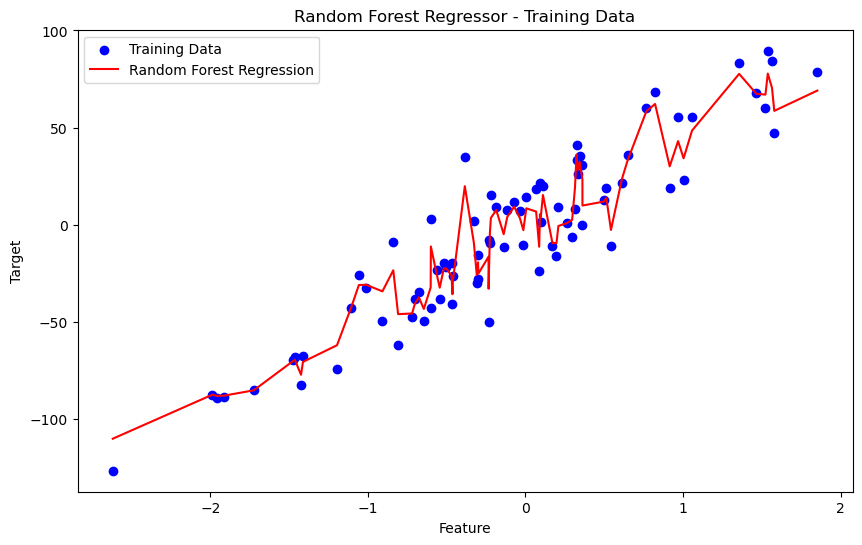

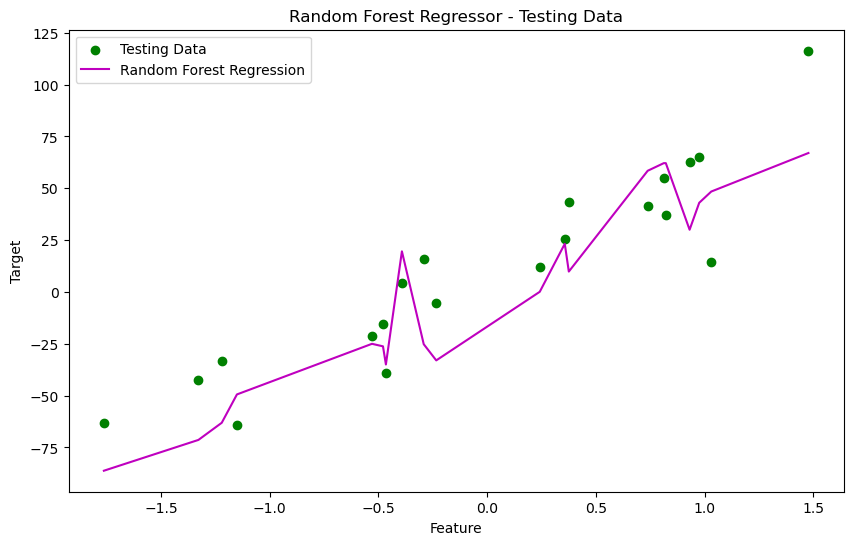

Mean Absolute Error (MAE): 57.50168377903081
Mean Squared Error (MSE): 5461.927041239809
Root Mean Squared Error (RMSE): 887020.8577308807
Mean Absolute Percentage Error (MAPE): 20.0


In [152]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Generate some synthetic data for demonstration
x, y = make_regression(n_samples=100, n_features=1, noise=20, random_state=42)

# Split data into training and testing sets
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
model=RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

# Visualize the training data
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, c='b', label='Training Data')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Random Forest Regressor - Training Data')

# Plot the regressor's predictions on training data
x_train_sorted = np.sort(x_train, axis=0)
y_train_pred = model.predict(x_train_sorted)
plt.plot(x_train_sorted, y_train_pred, c='r', label='Random Forest Regression')

plt.legend()
plt.show()

# Visualize the testing data
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, c='g', label='Testing Data')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Random Forest Regressor - Testing Data')

# Plot the regressor's predictions on testing data
x_test_sorted = np.sort(x_test, axis=0)
y_test_pred = model.predict(x_test_sorted)
plt.plot(x_test_sorted, y_test_pred, c='m', label='Random Forest Regression')

plt.legend()
plt.show()

# Evaluate forecast
mae_rfr = mean_absolute_error(y_test, y_test_pred)
mse_rfr = mean_squared_error(y_test, y_test_pred)
rmse_rfr = np.sqrt(mse)
mape_rfr = np.mean(np.abs(y_test, y_test_pred) / y_test) * 100

print("Mean Absolute Error (MAE):", mae_rfr)
print("Mean Squared Error (MSE):", mse_rfr)
print("Root Mean Squared Error (RMSE):", rmse_rfr)
print("Mean Absolute Percentage Error (MAPE):", mape_rfr)


ELECTRIC CAR SALES IN USA, 2019 ANALYSIS

In [153]:
df = pd.read_csv('Electric Car Sales by Model in USA.csv')

In [154]:
df.head()

,Make,Model,Logo,janv-12,12-Feb,mars-12,12-Apr,12-May,juin-12,juil-12,...,mars-19,19-Apr,19-May,juin-19,juil-19,19-Aug,19-Sep,19-Oct,19-Nov,19-Dec
0,Chevrolet,Volt,https://www.carlogos.org/logo/Chevrolet-logo-2...,603.0,1626.0,3915.0,5377.0,7057.0,8817.0,10666.0,...,146667.0,147072.0,"147,48","147,813","148,063","148,337","148,687","148,757","148,907","149,057"
1,Toyota,Prius PHV,https://www.carlogos.org/logo/Toyota-logo-1989...,0.0,21.0,912.0,2566.0,3652.0,4347.0,5035.0,...,42345.0,42345.0,42345,42345,42345,42345,42345,42345,42345,42345
2,Nissan,Leaf,https://www.carlogos.org/logo/Nissan-logo-2013...,676.0,1154.0,1733.0,2103.0,2613.0,3148.0,3543.0,...,122534.0,123485.0,"124,701","125,857","126,795","127,912","128,96","129,847","130,987","132,214"
3,Tesla,Model S,https://www.carlogos.org/logo/Tesla-logo-2003-...,0.0,NaN,NaN,NaN,NaN,12.0,31.0,...,147517.0,148342.0,"149,367","151,117","152,092","153,142","154,242","154,992","156,492","157,992"
4,Ford,C-Max Energi,https://www.carlogos.org/logo/Ford-logo-2003-1...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,42231.0,42231.0,42231,42231,42231,42231,42231,42231,42231,42231


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 99 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Make     57 non-null     object 
 1   Model    57 non-null     object 
 2   Logo     56 non-null     object 
 3   janv-12  12 non-null     float64
 4   12-Feb   5 non-null      float64
 5   mars-12  5 non-null      float64
 6   12-Apr   5 non-null      float64
 7   12-May   5 non-null      float64
 8   juin-12  6 non-null      float64
 9   juil-12  7 non-null      float64
 10  12-Aug   7 non-null      float64
 11  12-Sep   8 non-null      float64
 12  12-Oct   9 non-null      float64
 13  12-Nov   9 non-null      float64
 14  12-Dec   9 non-null      float64
 15  janv-13  11 non-null     float64
 16  13-Feb   12 non-null     float64
 17  mars-13  12 non-null     float64
 18  13-Apr   12 non-null     float64
 19  13-May   12 non-null     float64
 20  juin-13  13 non-null     float64
 21  juil-13  14 non-nu

In [156]:
df.describe()

,janv-12,12-Feb,mars-12,12-Apr,12-May,juin-12,juil-12,12-Aug,12-Sep,12-Oct,...,juil-18,18-Aug,18-Sep,18-Oct,18-Nov,18-Dec,janv-19,19-Feb,mars-19,19-Apr
count,12.00000,5.000000,5.000000,5.000000,5.00000,6.000000,7.000000,7.000000,8.000000,9.000000,...,51.000000,51.000000,51.000000,52.000000,52.000000,52.000000,52.000000,54.000000,54.00000,56.000000
mean,109.75000,576.600000,1339.600000,2052.600000,2726.00000,2792.333333,2826.142857,3495.571429,3776.750000,4144.222222,...,17665.392157,18378.078431,19251.490196,19536.538462,20355.538462,21315.153846,21636.596154,21148.037037,21659.87037,21265.857143
std,248.14663,761.593592,1597.507214,2173.677138,2867.96121,3460.736665,3998.150340,5028.241603,5860.291674,6685.544775,...,31245.890964,32069.417040,33374.899890,34195.421711,35649.485063,37602.323661,38176.981167,38199.220104,39249.31977,39596.394016
min,0.00000,2.000000,2.000000,2.000000,8.00000,12.000000,7.000000,16.000000,32.000000,48.000000,...,35.000000,35.000000,35.000000,5.000000,35.000000,35.000000,35.000000,16.000000,35.00000,35.000000
25%,0.00000,21.000000,136.000000,215.000000,300.00000,156.000000,83.000000,121.500000,135.250000,144.000000,...,1469.000000,1663.000000,1787.000000,1759.500000,1823.750000,1936.000000,1959.000000,1749.500000,1847.50000,1438.250000
50%,0.00000,80.000000,912.000000,2103.000000,2613.00000,1740.500000,366.000000,403.000000,333.500000,460.000000,...,5258.000000,5325.000000,5380.000000,5424.000000,5555.500000,5679.000000,5738.000000,5149.500000,5365.50000,4853.500000
75%,10.50000,1154.000000,1733.000000,2566.000000,3652.00000,4047.250000,4289.000000,5155.000000,5842.500000,6791.000000,...,14194.000000,14342.000000,14461.500000,15190.250000,16528.750000,17378.750000,17730.000000,16008.250000,16173.00000,15211.250000
max,676.00000,1626.000000,3915.000000,5377.000000,7057.00000,8817.000000,10666.000000,13497.000000,16348.000000,19309.000000,...,135130.000000,136955.000000,139084.000000,140559.000000,143089.000000,144147.000000,148046.000000,153796.000000,163971.00000,174021.000000


In [157]:
df.dropna(inplace=True)

In [158]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Make       0
Model      0
Logo       0
janv-12    0
12-Feb     0
          ..
19-Aug     0
19-Sep     0
19-Oct     0
19-Nov     0
19-Dec     0
Length: 99, dtype: int64


In [159]:
df.drop_duplicates(inplace=True)

In [160]:
melted_df = pd.melt(df, id_vars =['Make','Model','Logo'], var_name='Date', value_name='Sales')
print("\nMelted DataFrame")
print(melted_df)


Melted DataFrame
           Make           Model  \
0     Chevrolet            Volt   
1        Toyota       Prius PHV   
2        Nissan            Leaf   
3          Ford  Focus Electric   
4    Mitsubishi          i-MiEV   
..          ...             ...   
475   Chevrolet            Volt   
476      Toyota       Prius PHV   
477      Nissan            Leaf   
478        Ford  Focus Electric   
479  Mitsubishi          i-MiEV   

                                                  Logo     Date    Sales  
0    https://www.carlogos.org/logo/Chevrolet-logo-2...  janv-12    603.0  
1    https://www.carlogos.org/logo/Toyota-logo-1989...  janv-12      0.0  
2    https://www.carlogos.org/logo/Nissan-logo-2013...  janv-12    676.0  
3    https://www.carlogos.org/logo/Ford-logo-2003-1...  janv-12      2.0  
4    https://www.carlogos.org/logo/Mitsubishi-logo-...  janv-12     36.0  
..                                                 ...      ...      ...  
475  https://www.carlogos.org/logo/C

In [161]:
for column in melted_df:
    melted_df['Sales']=melted_df['Sales'].str.replace(',','.')

print(melted_df)

           Make           Model  \
0     Chevrolet            Volt   
1        Toyota       Prius PHV   
2        Nissan            Leaf   
3          Ford  Focus Electric   
4    Mitsubishi          i-MiEV   
..          ...             ...   
475   Chevrolet            Volt   
476      Toyota       Prius PHV   
477      Nissan            Leaf   
478        Ford  Focus Electric   
479  Mitsubishi          i-MiEV   

                                                  Logo     Date    Sales  
0    https://www.carlogos.org/logo/Chevrolet-logo-2...  janv-12      NaN  
1    https://www.carlogos.org/logo/Toyota-logo-1989...  janv-12      NaN  
2    https://www.carlogos.org/logo/Nissan-logo-2013...  janv-12      NaN  
3    https://www.carlogos.org/logo/Ford-logo-2003-1...  janv-12      NaN  
4    https://www.carlogos.org/logo/Mitsubishi-logo-...  janv-12      NaN  
..                                                 ...      ...      ...  
475  https://www.carlogos.org/logo/Chevrolet-logo-2...

In [162]:
   print(melted_df['Sales'].describe())

count       40
unique      19
top       9242
freq         8
Name: Sales, dtype: object


In [163]:
melted_df['Sales']=melted_df['Sales'].str.replace(' ','').astype(float)

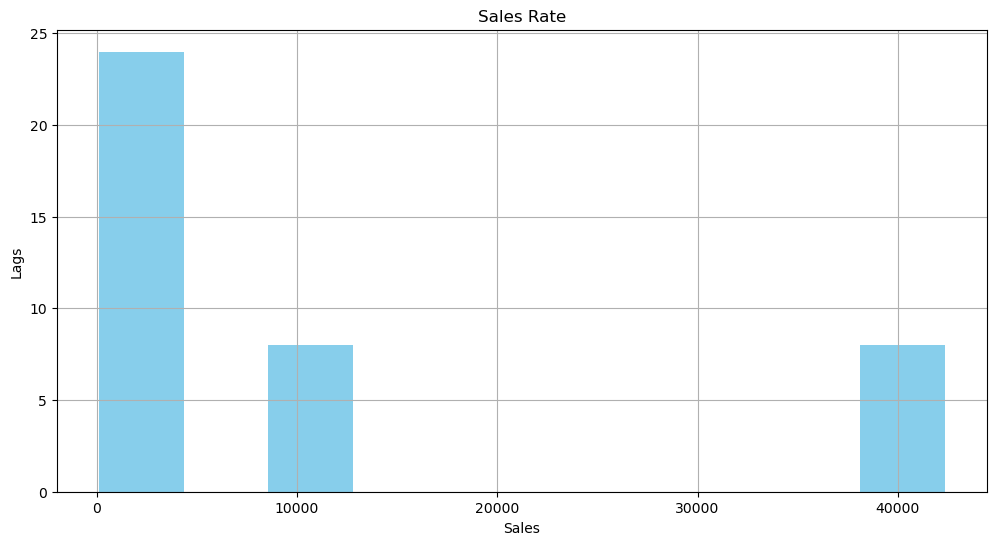

In [164]:
plt.figure(figsize=(12,6))
plt.hist(melted_df['Sales'].astype(float), bins=10, color='skyblue')
plt.xlabel('Sales')
plt.ylabel('Lags')
plt.title('Sales Rate')
plt.grid(True)
plt.show()

In [165]:
df = pd.read_csv('IEA-EV-dataEV salesCarsHistorical.csv')
df.head()


,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49
1,Australia,Historical,EV sales,Cars,BEV,2012,Vehicles,170
2,Australia,Historical,EV sales,Cars,PHEV,2012,Vehicles,80
3,Australia,Historical,EV sales,Cars,PHEV,2013,Vehicles,100
4,Australia,Historical,EV sales,Cars,BEV,2013,Vehicles,190


In [166]:
df.dtypes

region        object
category      object
parameter     object
mode          object
powertrain    object
year           int64
unit          object
value          int64
dtype: object

In [167]:
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.set_index('year', inplace=True)

In [232]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Sample time series data
df = pd.read_csv('IEA-EV-dataEV salesCarsHistorical.csv')
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.set_index('year', inplace=True)

df.sort_values(by='year', inplace=True)

# Filter out non-numeric columns
numeric_columns = [column for column in df.columns if pd.api.types.is_numeric_dtype(df[column])]


# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div([
    html.H1("Time Series Dashboard"),

    html.Div([
        html.Div([
            dcc.Dropdown(
                id='dropdown',
                options=[
                    {'label': column, 'value': column} for column in numeric_columns
                ],
                value=numeric_columns[0]
            ),
            dcc.Graph(id='time-series-plot')
        ], className='six columns'),
        
        html.Div([
            dcc.Graph(id='seasonal-decomposition-plot')
        ], className='six columns'),
        
    ], className='row'),
    
    html.Div([
        dcc.RangeSlider(
            id='date-range-slider',
            marks={i: str(df.index[i].date()) for i in range(0, len(df.index), len(df.index)//10)},
            min=0,
            max=len(df.index)-1,
            value=[0, len(df.index)-1]
        )
    ]),
    
    html.Div(id='output-div'),
    
    # Statistical analysis section
    html.Div(id='statistical-analysis')
])

# Define callback to update the time series plot based on dropdown selection and date range slider
@app.callback(
    [Output('time-series-plot', 'figure'),
     Output('seasonal-decomposition-plot', 'figure')],
    [Input('dropdown', 'value'),
     Input('date-range-slider', 'value')]
)
def forecast_plot(selected_column, date_range):
    filtered_df = df.iloc[date_range[0]:date_range[1]+1]
    
    # Update time series plot
    time_series_trace = go.Scatter(
        x=filtered_df.index,
        y=filtered_df[selected_column],
        mode='lines',
        name=selected_column)
    time_series_layout = go.Layout(
        title=f'Time Series Plot for {selected_column}',
        xaxis={'title': 'SNo.'},
        yaxis={'title': 'Value'})
    time_series_figure = {'data': [time_series_trace], 'layout': time_series_layout}
    
    
    # Perform seasonal decomposition and update decomposition plot
    decomposition_result = seasonal_decompose(filtered_df[selected_column], model='additive', period=12)
    seasonal_trace = go.Scatter(
        x=filtered_df.index,
        y=decomposition_result.seasonal,
        mode='lines',
        name='Seasonal Component')
    trend_trace = go.Scatter(
        x=filtered_df.index,
        y=decomposition_result.trend,
        mode='lines',
        name='Trend Component')
    residual_trace = go.Scatter(
        x=filtered_df.index,
        y=decomposition_result.resid,
        mode='lines',
        name='Residual Component')
    decomposition_layout = go.Layout(
        title=f'Seasonal Decomposition for {selected_column}',
        xaxis={'title': 'SNo.'},
        yaxis={'title': 'Value'},
        showlegend=True)
    decomposition_figure = {'data': [seasonal_trace, trend_trace, residual_trace], 'layout': decomposition_layout}
    return time_series_figure, decomposition_figure

# Callback to update statistical analysis section
@app.callback(Output('statistical-analysis', 'children'),[Input('dropdown', 'value')])
def update_statistical_analysis(selected_column):
    stats = df[selected_column].describe().to_frame().reset_index().rename(columns={'index': 'Stat'})
    return html.Table(
        [html.Tr([html.Th(col) for col in stats.columns])] +
        [html.Tr([html.Td(stats.iloc[i][col]) for col in stats.columns]) for i in range(len(stats))])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8059)


## Task 1

## Comparison:
- MAE: The ARIMA model has the highest MAE, indicating it has the highest average absolute error compared to the other models.

- MSE: The ARIMA model also has the highest MSE, suggesting it has larger errors on average squared compared to the other models.

- RMSE: The RMSE values are the same for all models since they use the same value in the calculation, however, ARIMA's high MAE and MSE values imply it also has the highest RMSE.

- MAPE: The ARIMA model again has the highest MAPE, indicating that its predictions are, on average, much farther from the actual values compared to the XGBoost and Light GBM models.

A Mean Absolute Percentage Error (MAPE) of 100% indicates that, on average, the absolute percentage difference between the forecasted values and the actual values is 100%. In other words, the forecasted values are, on average, equal to the actual values.

## Conclusion:
Based on these evaluation metrics, both XGBoost and Light GBM models outperform the ARIMA model. They have significantly lower errors (MAE, MSE, MAPE), suggesting better predictive performance. However, since XGBoost and Light GBM have similar evaluation results, further analysis or fine-tuning may be needed to determine which one performs better for your specific dataset and task.